<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/development/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
torch.manual_seed(1)

# Ignore everything above

In [ ]:
df = pd.read_parquet('MKE.parquet')
df['valid'] = pd.to_datetime(df['valid'])

# Filter for the years 2020 and 2021
df_filtered = df[df['valid'].dt.year.isin([2020, 2020])]
df = pd.DataFrame(df_filtered)
df['valid'] = pd.to_datetime(df['valid']) + timedelta(minutes=8)

first_row = df.iloc[0].copy()
first_row['valid'] = first_row['valid'].replace(hour=0, minute=0, second=0, microsecond=0)

df = pd.concat([pd.DataFrame([first_row]), df]).reset_index(drop=True)
weather_df = df[:-1]
weather_df = weather_df.rename(columns={'valid': 'Datetime'})

pm10_df = pd.read_csv("/content/cleaned_MKE_2020_pm10.csv")
pm25_df = pd.read_csv("/content/split_0_8765.csv")
so2_df = pd.read_csv("/content/cleaned_MKE_2020_so2.csv")

pm25_df['Datetime'] = pd.to_datetime(pm25_df['Date Local'] + ' ' + pm25_df['Time Local'])
pm25_df = pm25_df[['Datetime', 'Sample Measurement']]
pm10_df['Datetime'] = pd.to_datetime(pm10_df['Date Local'] + ' ' + pm10_df['Time Local'])
pm10_df = pm10_df[['Datetime', 'Sample Measurement']]
so2_df['Datetime'] = pd.to_datetime(so2_df['Date Local'] + ' ' + so2_df['Time Local'])
so2_df = so2_df[['Datetime', 'Sample Measurement']]


imp = SimpleImputer(strategy="most_frequent")
def infill(df1):
  df = df1.set_index('Datetime')

  # Create complete hourly range
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
  return df.reindex(full_range)

pm10_df = infill(pm10_df)
pm10_df = imp.fit_transform(pm10_df)
pm25_df = infill(pm25_df)
pm25_df = imp.fit_transform(pm25_df)
so2_df  = infill(so2_df)
so2_df  = imp.fit_transform(so2_df)
weather_df = infill(weather_df)
weather_df = imp.fit_transform(weather_df)

#pm10_df = np.concatenate((pm10_df, weather_df), axis=1)
#pm25_df = np.concatenate((pm25_df, weather_df), axis=1)
#so2_df = np.concatenate((so2_df, weather_df), axis=1)

print(pm10_df.shape)
print(pm25_df.shape)
print(so2_df.shape)

(8784, 1)
(8784, 1)
(8784, 1)


In [ ]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
# NORMALIZING
pm25_timeseries = pm25_df.astype('float32')
pm10_timeseries = pm10_df.astype('float32')
so2_timeseries = so2_df.astype('float32')

pm25_train_size = int(len(pm25_timeseries) * 0.75)
pm25_test_size = len(pm25_timeseries) - pm25_train_size
pm25_train, pm25_test = pm25_timeseries[:pm25_train_size], pm25_timeseries[pm25_train_size:]
print(pm25_train.shape, pm25_test.shape)

pm10_train_size = int(len(pm10_timeseries) * 0.75)
pm10_test_size = len(pm10_timeseries) - pm10_train_size
pm10_train, pm10_test = pm10_timeseries[:pm10_train_size], pm10_timeseries[pm10_train_size:]
print(pm10_train.shape, pm10_test.shape)

so2_train_size = int(len(so2_timeseries) * 0.75)
so2_test_size = len(so2_timeseries) - so2_train_size
so2_train, so2_test = so2_timeseries[:so2_train_size], so2_timeseries[so2_train_size:]
print(so2_train.shape, so2_test.shape)

(6588, 1) (2196, 1)
(6588, 1) (2196, 1)
(6588, 1) (2196, 1)


In [ ]:
lookback = 7
pm25_X_train, pm25_y_train = create_dataset(pm25_train, lookback=lookback)
pm25_X_test, pm25_y_test = create_dataset(pm25_test, lookback=lookback)

print(pm25_X_train.shape, pm25_y_train.shape)
print(pm25_X_test.shape, pm25_y_test.shape)

pm10_X_train, pm10_y_train = create_dataset(pm10_train, lookback=lookback)
pm10_X_test, pm10_y_test = create_dataset(pm10_test, lookback=lookback)
print(pm10_X_train.shape, pm10_y_train.shape)
print(pm10_X_test.shape, pm10_y_test.shape)

so2_X_train, so2_y_train = create_dataset(so2_train, lookback=lookback)
so2_X_test, so2_y_test = create_dataset(so2_test, lookback=lookback)
print(so2_X_train.shape, so2_y_train.shape)
print(so2_X_test.shape, so2_y_test.shape)

torch.Size([6581, 7, 1]) torch.Size([6581, 7, 1])
torch.Size([2189, 7, 1]) torch.Size([2189, 7, 1])
torch.Size([6581, 7, 1]) torch.Size([6581, 7, 1])
torch.Size([2189, 7, 1]) torch.Size([2189, 7, 1])
torch.Size([6581, 7, 1]) torch.Size([6581, 7, 1])
torch.Size([2189, 7, 1]) torch.Size([2189, 7, 1])


In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
import torch.optim as optim
import torch.utils.data as data

def r2_score(predicted, target):
    mean_target = torch.mean(target)
    total_variance = torch.sum((target - mean_target)**2)
    residual_variance = torch.sum((target - predicted)**2)

    r_squared = 1 - (residual_variance / total_variance)

    return r_squared.item()  # Convert the tensor to a Python float


pm25_loader = data.DataLoader(data.TensorDataset(pm25_X_train, pm25_y_train), shuffle=True, batch_size=8)
pm10_loader = data.DataLoader(data.TensorDataset(pm10_X_train, pm10_y_train), shuffle=True, batch_size=8)
so2_loader = data.DataLoader(data.TensorDataset(so2_X_train, so2_y_train), shuffle=True, batch_size=8)

def models(X_train, y_train, X_test, y_test, loader, input_size):
  model = LSTM_Model(input_size)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  loss_fn = nn.MSELoss()
  losses = []
  n_epochs = 100
  for epoch in range(n_epochs):
      model.train()
      avg_loss = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          avg_loss.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      losses.append(np.mean(avg_loss))
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          r2_score_train = r2_score(y_pred, y_train)

          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          r2_score_test = r2_score(y_pred, y_test)

      print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, r2_score_train, r2_score_test))
  return model, losses
print("PM 2.5 Model")
pm25_model, pm25_losses = models(pm25_X_train, pm25_y_train, pm25_X_test, pm25_y_test, pm25_loader, 1)
print("PM 10 Model")
pm10_model, pm10_losses = models(pm10_X_train, pm10_y_train, pm10_X_test, pm10_y_test, pm10_loader, 1)
print("SO2 Model")
so2_model, so2_losses = models(so2_X_train, so2_y_train, so2_X_test, so2_y_test, so2_loader, 1)



PM 2.5 Model
Epoch 0: train RMSE 2.6378, test RMSE 2.2209, train R2 0.7950, test R2 0.8665
Epoch 1: train RMSE 2.4783, test RMSE 2.0268, train R2 0.8191, test R2 0.8888
Epoch 2: train RMSE 2.3727, test RMSE 1.9822, train R2 0.8342, test R2 0.8936
Epoch 3: train RMSE 2.3482, test RMSE 2.0193, train R2 0.8376, test R2 0.8896
Epoch 4: train RMSE 2.3003, test RMSE 1.9848, train R2 0.8441, test R2 0.8934
Epoch 5: train RMSE 2.3093, test RMSE 1.9952, train R2 0.8429, test R2 0.8922
Epoch 6: train RMSE 2.2573, test RMSE 1.9666, train R2 0.8499, test R2 0.8953
Epoch 7: train RMSE 2.2441, test RMSE 1.9254, train R2 0.8517, test R2 0.8996
Epoch 8: train RMSE 2.2196, test RMSE 1.9406, train R2 0.8549, test R2 0.8981
Epoch 9: train RMSE 2.2127, test RMSE 1.9358, train R2 0.8558, test R2 0.8986
Epoch 10: train RMSE 2.1982, test RMSE 1.9561, train R2 0.8577, test R2 0.8964
Epoch 11: train RMSE 2.1832, test RMSE 1.9222, train R2 0.8596, test R2 0.9000
Epoch 12: train RMSE 2.1812, test RMSE 1.9288, tr

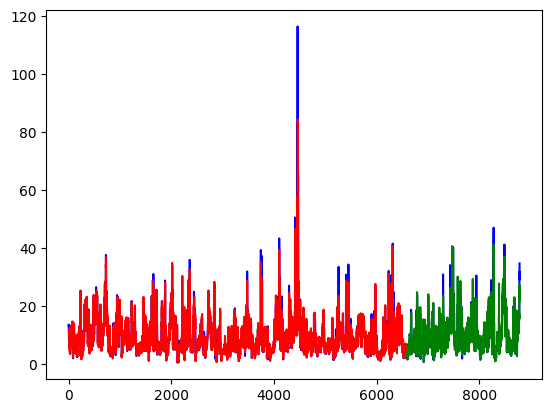

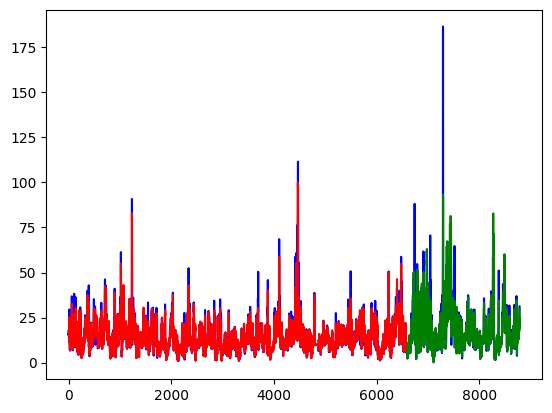

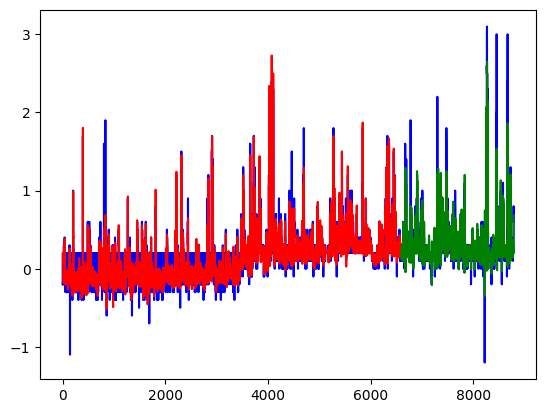

In [ ]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='b')
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()

pm25_timeseries = pm25_df.astype('float32')
pm25_train_size = int(len(pm25_timeseries) * 0.75)
pm25_test_size = len(pm25_timeseries) - pm25_train_size
pm25_train, pm25_test = pm25_timeseries[:pm25_train_size], pm25_timeseries[pm25_train_size:]
pm25_X_train, pm25_y_train = create_dataset(pm25_train, lookback=lookback)
pm25_X_test, pm25_y_test = create_dataset(pm25_test, lookback=lookback)


plot(pm25_model, pm25_timeseries, pm25_train_size, pm25_X_train, pm25_y_train, pm25_X_test, pm25_y_test)
plot(pm10_model, pm10_timeseries, pm10_train_size, pm10_X_train, pm10_y_train, pm10_X_test, pm10_y_test)
plot(so2_model, so2_timeseries, so2_train_size, so2_X_train, so2_y_train, so2_X_test, so2_y_test)
#plot(weather_model, weather_timeseries, weather_train_size, weather_X_train, weather_y_train, weather_X_test, weather_y_test)

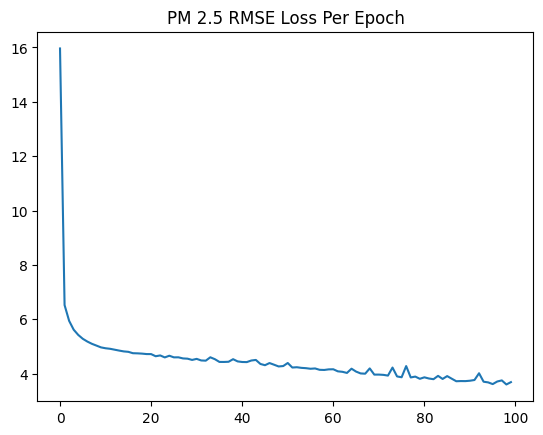

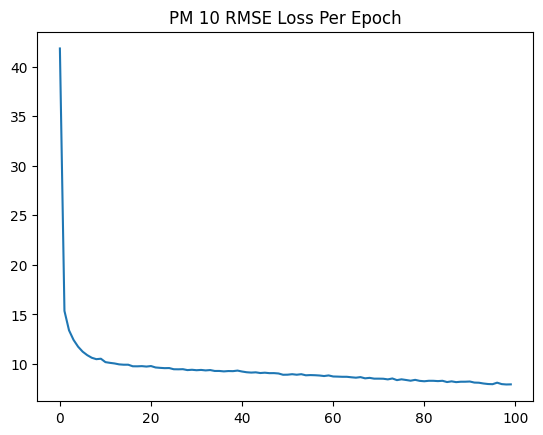

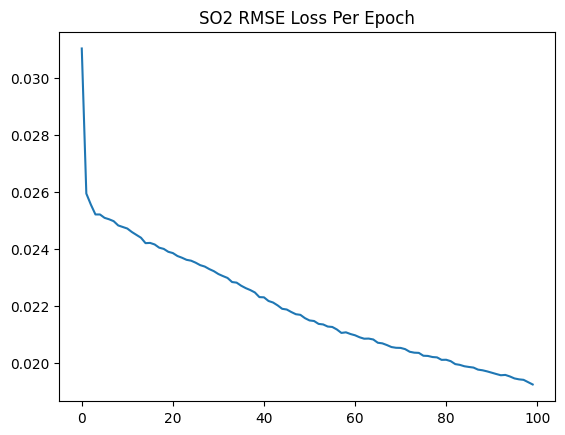

In [ ]:
plt.title("PM 2.5 RMSE Loss Per Epoch")
plt.plot(pm25_losses, label="pm25 loss")
plt.show()
plt.title("PM 10 RMSE Loss Per Epoch")
plt.plot(pm10_losses, label="pm10 loss")
plt.show()
plt.title("SO2 RMSE Loss Per Epoch")
plt.plot(so2_losses, label="so2 loss")
plt.show()